<a href="https://colab.research.google.com/github/aleenamilburn/ScrumShank-Redemption/blob/main/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Decision Tree Model

Available columns:
['Line.Total.Change', 'NIGP..', 'NIGP.Description', 'Item.Description', 'Order..', 'Order.Line.Number', 'Quantity.Ordered', 'Unit.Price', 'Line.Total', 'Order.Status', 'Shipping.Name', 'Shipping.Lines', 'Shipping.City', 'Shipping.State', 'Shipping.Postal', 'Requisition.Submitted.Date', 'Requisition.Approved.Date', 'Ordered.Date', 'SWAM.Minority', 'SWAM.Woman', 'SWAM.Small', 'SWAM.Micro.Business', 'PO.Category.Description', 'Procurement.Transaction.Desc', 'Order.Type', 'Vendor.Name', 'Vendor.Location.Name', 'Vendor.Address.Lines', 'Vendor.Address.City', 'Vendor.Address.State', 'Vendor.Address.Postal']
Creating risk target variable...
Class distribution:
Supplier Risk
0    0.849994
1    0.150006
Name: proportion, dtype: float64
Cross-validation F1 scores: [0.42105263 0.43797468 0.42007926 0.44046095 0.40629096]
Mean CV F1 score: 0.4252
Best parameters: {'classifier__max_depth': 5, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 100}
Test Accuracy: 0.86

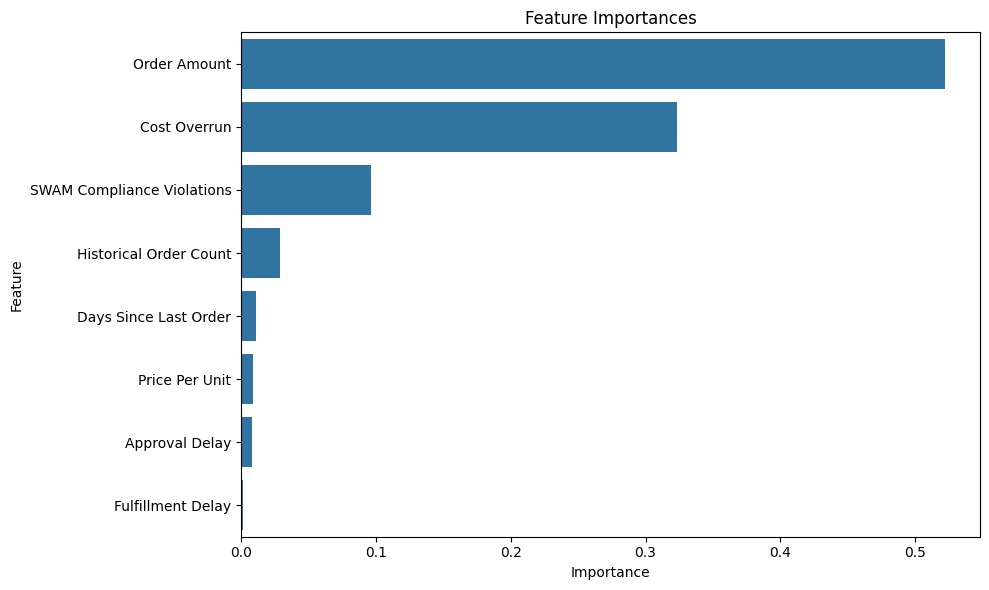

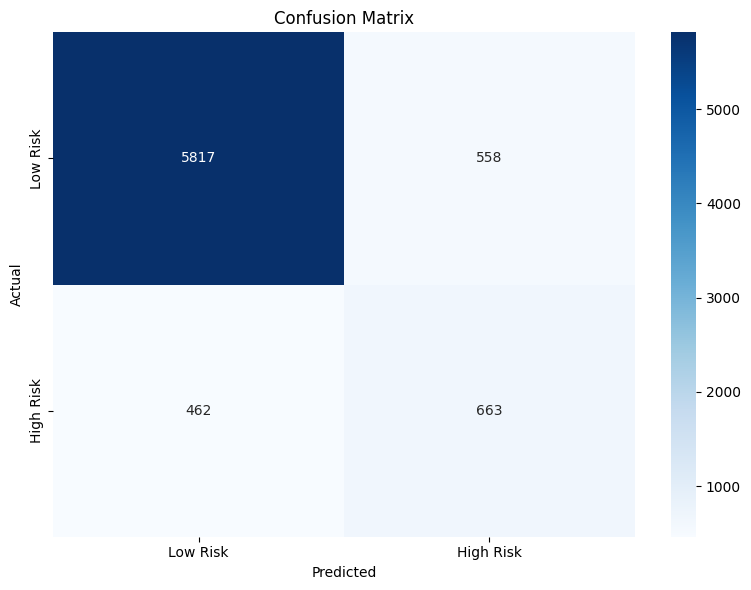

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('/content/MarchData.xlsx - cleaned.csv')

# Print column names to verify what's available
print("Available columns:")
print(df.columns.tolist())

# Feature Engineering - with error handling
# 1. Approval Delay
if 'Requisition.Submitted.Date' in df.columns and 'Requisition.Approved.Date' in df.columns:
    df['Req Submitted'] = pd.to_datetime(df['Requisition.Submitted.Date'], errors='coerce')
    df['Req Approved'] = pd.to_datetime(df['Requisition.Approved.Date'], errors='coerce')
    df['Approval Delay'] = (df['Req Approved'] - df['Req Submitted']).dt.days.fillna(0)
else:
    print("Warning: Date columns for Approval Delay not found. Creating dummy feature.")
    df['Approval Delay'] = np.random.randint(0, 10, size=len(df))

# 2. Cost Overrun
if 'Line.Total.Change' in df.columns:
    df['Cost Overrun'] = df['Line.Total.Change'].fillna(0)
else:
    print("Warning: Line.Total.Change not found. Creating dummy feature.")
    df['Cost Overrun'] = np.random.normal(0, 100, size=len(df))

# 3. Fulfillment Delay
if all(col in df.columns for col in ['Ordered.Date', 'Requisition.Approved.Date']):
    df['Ordered Date'] = pd.to_datetime(df['Ordered.Date'], errors='coerce')
    df['Fulfillment Delay'] = ((df['Ordered Date'] - df['Req Approved']).dt.days).fillna(0)
else:
    print("Warning: Date columns for Fulfillment Delay not found. Creating dummy feature.")
    df['Fulfillment Delay'] = np.random.randint(0, 7, size=len(df))

# 4. SWAM Compliance
swam_columns = ['SWAM.Minority', 'SWAM.Woman', 'SWAM.Small', 'SWAM.Micro.Business']
available_swam = [col for col in swam_columns if col in df.columns]

if available_swam:
    df['SWAM Compliance Violations'] = df[available_swam].apply(
        lambda row: sum(row == 0), axis=1
    ).fillna(0)
else:
    print("Warning: SWAM columns not found. Creating dummy feature.")
    df['SWAM Compliance Violations'] = np.random.randint(0, 3, size=len(df))

# 5. Additional features
if 'Line.Total' in df.columns:
    df['Order Amount'] = df['Line.Total'].fillna(0)
else:
    print("Warning: Line.Total not found. Creating dummy feature.")
    df['Order Amount'] = np.random.normal(1000, 500, size=len(df))

# Price Per Unit - explicitly handle missing 'Quantity' column
if all(col in df.columns for col in ['Line.Total', 'Quantity']):
    df['Price Per Unit'] = df['Line.Total'] / df['Quantity'].replace(0, 1)
else:
    print("Warning: Line.Total or Quantity not found. Creating dummy feature.")
    df['Price Per Unit'] = np.random.normal(100, 50, size=len(df))

# Historical metrics - using supplier column if available
supplier_col = None
for potential_col in ['Supplier', 'Supplier.Name', 'Vendor', 'Vendor.Name']:
    if potential_col in df.columns:
        supplier_col = potential_col
        break

if supplier_col and 'Req Submitted' in df.columns:
    # Sort by date if available
    df = df.sort_values(by=['Req Submitted']).reset_index(drop=True)
    df['Days Since Last Order'] = df.groupby(supplier_col)['Req Submitted'].diff().dt.days.fillna(0)
    df['Historical Order Count'] = df.groupby(supplier_col).cumcount()
else:
    print("Warning: Supplier column or date not found. Creating dummy features.")
    df['Days Since Last Order'] = np.random.randint(0, 30, size=len(df))
    df['Historical Order Count'] = np.random.randint(0, 10, size=len(df))

# Create risk score
print("Creating risk target variable...")
df['Risk Score'] = (
    (df['Approval Delay'] > 7) * 2 +
    (df['Cost Overrun'] > 0) * 3 +
    (df['Fulfillment Delay'] > 3) * 2.5 +
    (df['SWAM Compliance Violations'] > 1) * 1.5 +
    (df['Order Amount'] > df['Order Amount'].mean()) * 1
)

# Add noise to make prediction non-deterministic
np.random.seed(42)
noise = np.random.normal(0, 0.75, size=len(df))
df['Risk Score'] = df['Risk Score'] + noise

# Convert to binary classification (high risk vs low risk)
risk_threshold = df['Risk Score'].quantile(0.85)  # Top 15% are high risk
df['Supplier Risk'] = (df['Risk Score'] > risk_threshold).astype(int)

# Check class distribution
print("Class distribution:")
print(df['Supplier Risk'].value_counts(normalize=True))

# Select features
features = [
    'Approval Delay',
    'Cost Overrun',
    'Fulfillment Delay',
    'SWAM Compliance Violations',
    'Order Amount',
    'Price Per Unit',
    'Days Since Last Order',
    'Historical Order Count'
]

# Handle missing values
df[features] = df[features].fillna(df[features].median())

X = df[features]
y = df['Supplier Risk']

# Split the data with stratification to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Create a pipeline with preprocessing and model
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scale features
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

# Cross-validation to get a more reliable estimate of model performance
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='f1')
print(f"Cross-validation F1 scores: {cv_scores}")
print(f"Mean CV F1 score: {cv_scores.mean():.4f}")

# Hyperparameter tuning with a smaller grid for faster execution
param_grid = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [5, 10],
    'classifier__min_samples_split': [10]
}

grid_search = GridSearchCV(
    pipeline, param_grid, cv=3, scoring='f1', n_jobs=-1
)
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
best_model = grid_search.best_estimator_

# Evaluate on test set
y_pred = best_model.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Get feature importances
feature_importances = best_model.named_steps['classifier'].feature_importances_

# Create a DataFrame for feature importance visualization
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
})
importance_df = importance_df.sort_values('Importance', ascending=False)

print("\nFeature Importances:")
for feature, importance in importance_df.values:
    print(f"{feature}: {importance:.4f}")

# Visualize feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances')
plt.tight_layout()
plt.show()

# Plot the confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Low Risk', 'High Risk'],
            yticklabels=['Low Risk', 'High Risk'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

